# Demystifying Deep Learning: An Intuitive Introduction to Neural Networks

_Supplementary Coding Notebook_

**Author**: Dr Musashi Jacobs-Harukawa, DDSS Princeton


In [1]:
# Some utilities
from tqdm import tqdm
from typing import Union, Optional, Literal

# Tools for creating toy datasets
from sklearn import datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

# Core libraries for deep learning and numerical computing
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

## Part 1: Linear Regression, Sort of Manually

- We begin in the familiar territory of trying to fit the best linear approximation of a relationship between two variables.
- This is something we do all the time in quantitative analysis - regression analysis.
- But whereas we previously focus on the model specification and interpretation part, this time we are going to focus on the "fitting" component.
- This exercise will help you understand a lot of the low-level operations that go on in neural networks!


Let's create some made-up data from scratch:

In [2]:
rng = np.random.default_rng(seed=0) # Reproducible random number generator
N_         = 100
coef_      = 3.4
intercept_ = 1.0
std_       = 1.3

X_ = rng.uniform(low=-5, high=5, size=N_).reshape(-1, 1)
y_ = coef_*X_ + intercept_ + rng.normal(loc=0, scale=std_, size=N_).reshape(-1, 1)

Note that even though I record the actual coefficient for the DGP, this won't be the optimal coefficient for the sampled data.

We can quickly check this by fitting a linear model (also from the `scikit-learn` library).

In [3]:
# OLS Model
lin_reg = LinearRegression()     # Instantiate linear regression model
lin_reg.fit(X_, y_)              # Fit to data
wOLS = lin_reg.coef_.item()      # .coef_ holds weights (betas) and
bOLS = lin_reg.intercept_.item() # .item() returns the scalar

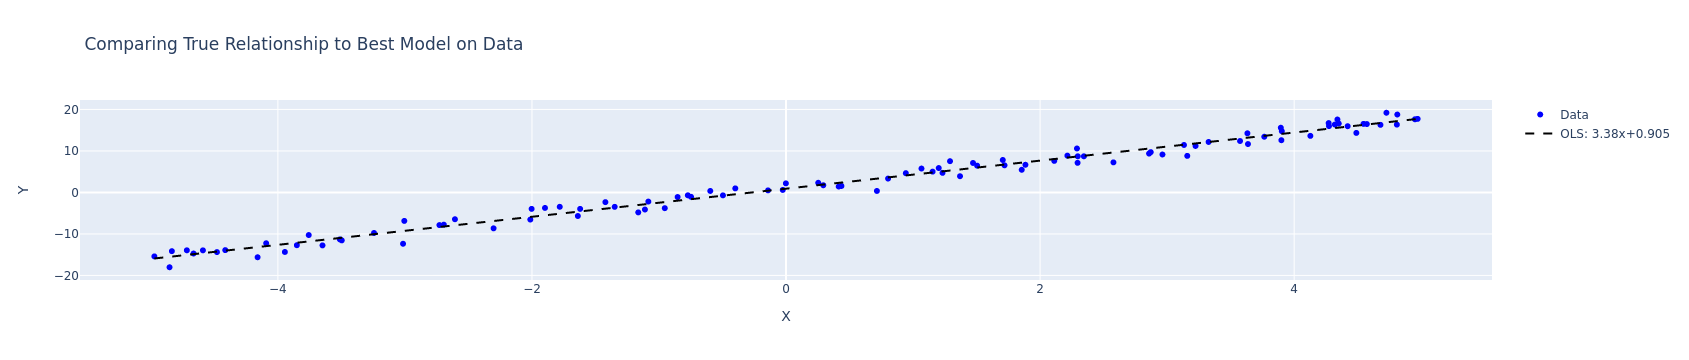

In [4]:
# Don't worry too much about the visualization code
# if you want to learn more let me know
fig = go.Figure()
fig.add_trace(go.Scatter(x=X_[:,0],
                         y=y_[:,0],
                         mode='markers',
                         marker_color='blue',
                         hovertemplate="%{x:.3g}, %{y:.3g}",
                         name='Data'))
fig.add_trace(go.Scatter(x=[X_.min(), X_.max()],
                         y=[X_.min() * wOLS + bOLS, X_.max() * wOLS + bOLS],
                         mode='lines',
                         name=f'OLS: {wOLS:.3g}x+{bOLS:.3g}',
                         # visible='legendonly',
                         hovertext=f"y = ({wOLS:.3g})x + {bOLS:.3g}",
                         line=dict(color='black', dash='dash')))
fig.update_layout(title='Comparing True Relationship to Best Model on Data',
                  xaxis_title='X',
                  yaxis_title='Y')

In this figure I show the data points, the "true" model based off of the data-generating process, and the best model for the data using the OLS method.

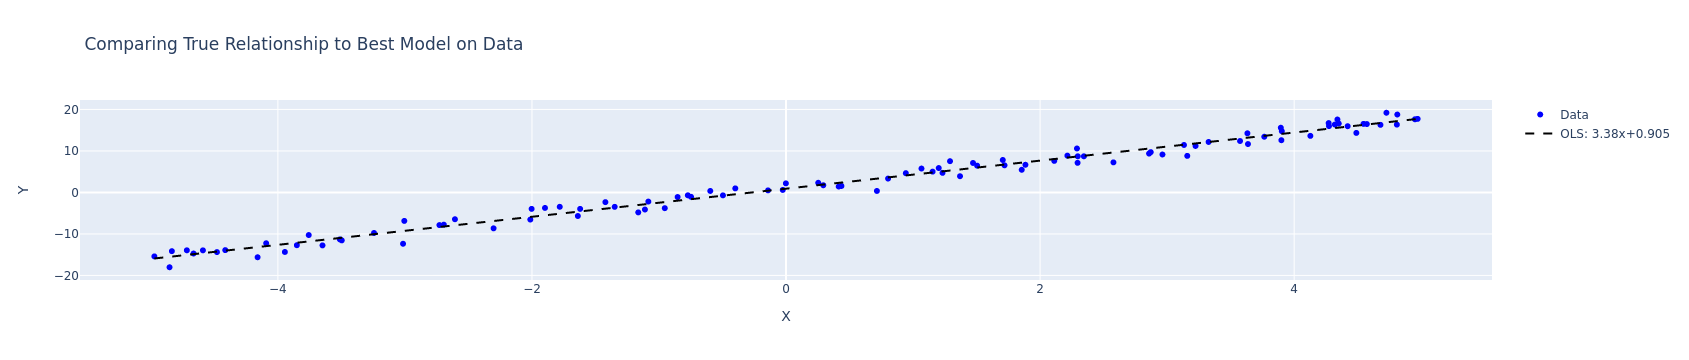

In [5]:
fig

### How do we fit a line to some data point?

- Take a guess
- Calculate how far 

`pytorch` offers built-in tools to conduct this process.

In [6]:
# Let's convert our data to PyTorch tensors (float dtype)
X_, y_ = torch.tensor(X_).float(), torch.tensor(y_).float()

# Fit model y = wx + b: learn w and b
# Creating tensors to store values of w and b
# Initializations as "empty"
w = torch.empty(1, 1, requires_grad=True)   # 1x1 uninitialised weight matrix
b = torch.empty(1, 1, requires_grad=True)   # 1x1 uninitialised bias matrix

For our first "guess", we can just use some random values.

There are more principled approaches to this step, but we skip this for now.

In [7]:
# We randomize the values of these coefficients
torch.manual_seed(0)
with torch.no_grad():                       # Will explain this later
    nn.init.normal_(w, mean=0, std=0.5)     # Fill with random values
    nn.init.normal_(b, mean=0, std=0.5)
print(w, b)

tensor([[0.7705]], requires_grad=True) tensor([[-0.1467]], requires_grad=True)


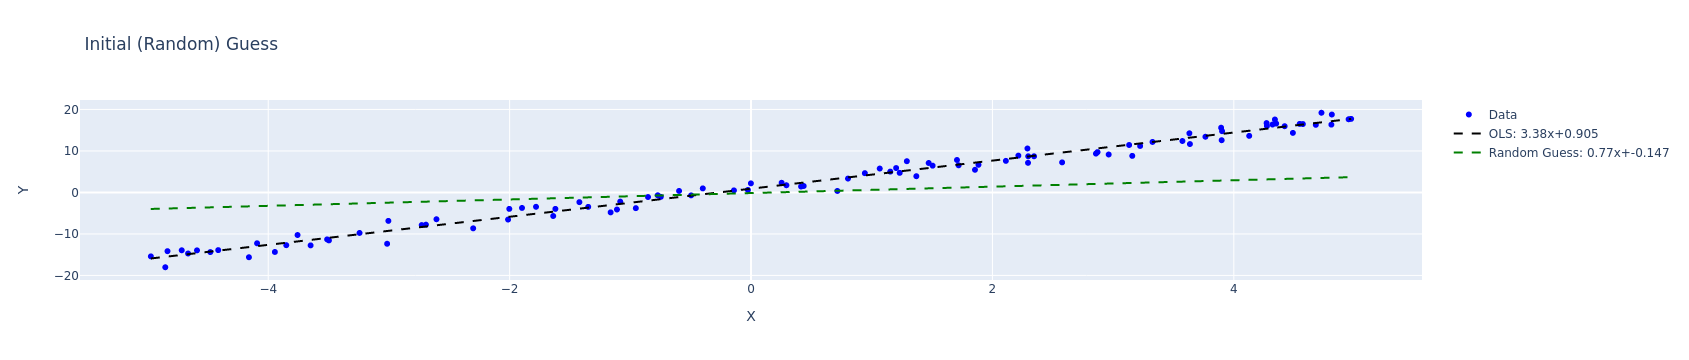

In [8]:
# %% What does this predict?
fig.add_trace(go.Scatter(x=[X_.min(), X_.max()],
                         y=[(X_.min() * w + b).detach().squeeze(), (X_.max() * w + b).detach().squeeze()],
                         mode='lines',
                         name=f'Random Guess: {w.item():.3g}x+{b.item():.3g}',
                         line=dict(color='green', dash='dash')))
fig.update_layout(title='Initial (Random) Guess')

What does this first guess look like?

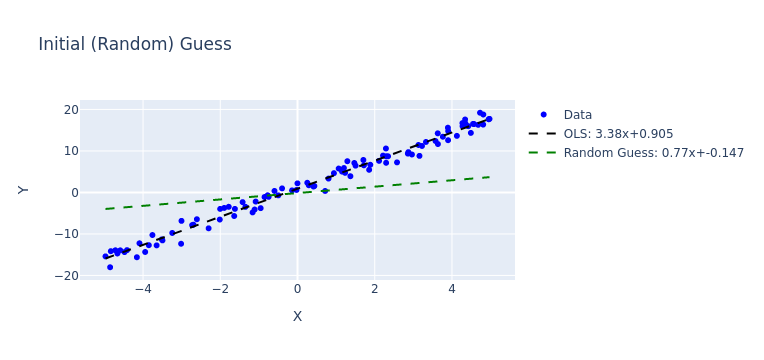

In [9]:
fig

How do we improve this guess?

Let's begin with a single point prediction.

In [10]:
# Let's begin with the first two points.
x0 = X_[0]
y0 = y_[0]

print(x0, y0, sep='\n')

tensor([1.3696])
tensor([3.9131])


Let's generate predictions for the value of `y` for each of these two points.

In [11]:
# Make prediction
yhat_ = x0 * w + b
print(yhat_)

tensor([[0.9086]], grad_fn=<AddBackward0>)


How wrong were we?

In [12]:
error = (y0 - yhat_)
print(error)

tensor([[3.0045]], grad_fn=<SubBackward0>)


However, we need a convex loss function (for reasons that will become clear):

In this case we square the error.

In [13]:
# Begin by defining the loss function: squared loss 
loss = (y0 - yhat_).pow(2)
loss

tensor([[9.0273]], grad_fn=<PowBackward0>)

How does this connect to increasing the accuracy of the model?

Think about the function measuring loss as a function of the weight and bias: $L(w, b)$

We want to know how we should adjust the changeable parameters ($w$ and $b$) in order to reduce the size of our mistake ($L$).

We can do this with a bit of calculus. The _partial derivative_ $\frac{\delta L}{\delta w}$ describes how $L$ changes as a function of $w$, holding all else constant.

Pytorch contains the tools to automatically calculate this, but let's do it by hand so that we make sure that we understand it.

Returning to the definition of a partial derivative (https://en.wikipedia.org/wiki/Partial_derivative#Definition):

$$
\lim_{h \to 0} \frac{f(x+h)-f(x)}{h}
$$

In [14]:
# Calculating a partial derivative by hand!
h = 0.0001                           # h as some arbitrarily small value
fx =  (y0 - (x0 *  w    + b)).pow(2) # f(x)   (squared loss)
fxh = (y0 - (x0 * (w+h) + b)).pow(2) # f(x+h)
dfx = (fxh-fx)/h                     # (f(x+h)-f(x))/h
print(dfx)

tensor([[-8.2302]], grad_fn=<DivBackward0>)


In [15]:
# Pytorch does it for us as well
if w.grad is not None:
    w.grad -= w.grad            # Set gradient to 0, if any
loss = (y0 - (x0*w + b)).pow(2) # Same loss calculation
loss.backward()                 # Calculate dL w.r.t. all parameters (w, b)
print(w.grad)                   # dL/dw stored on tensor w

tensor([[-8.2301]])


What do we do with $\frac{\delta L}{\delta w}$ and $\frac{\delta L}{\delta b}$?

We want to adjust the parameters in the direction of smaller loss.

(Think about it--if $\frac{\delta L}{\delta w}$ is positive and we increase w, then $L$ will increase!)

This is easiest to see if we visualize $L(w)$ and $\frac{\delta L}{\delta w}$.

In [16]:
# See if you can follow this code here
wvals = []
for wval in np.linspace(-5, 5, 100):
    wval = torch.tensor([wval], requires_grad=True).float()
    wval.retain_grad()
    loss = (y0 - (x0 * wval + b)).pow(2)
    loss.backward()
    wvals.append([wval.item(), loss.item(), wval.grad.item()])

# Make a figure from this
temp = go.Figure(
    data=[go.Scatter(x=[witem[0] for witem in wvals],
                         y=[witem[1] for witem in wvals],
                         name='L(w)',
                         mode='markers+lines'),
          go.Scatter(x=[witem[0] for witem in wvals],
                         y=[witem[2] for witem in wvals],
                         name='dL/dw',
                         mode='markers+lines')],
    layout=dict(title='Squared Loss vs Loss Gradient for Varying Values of w',
                  xaxis_title='w Parameter Value',
                  yaxis_title='Loss, dL/dw'))

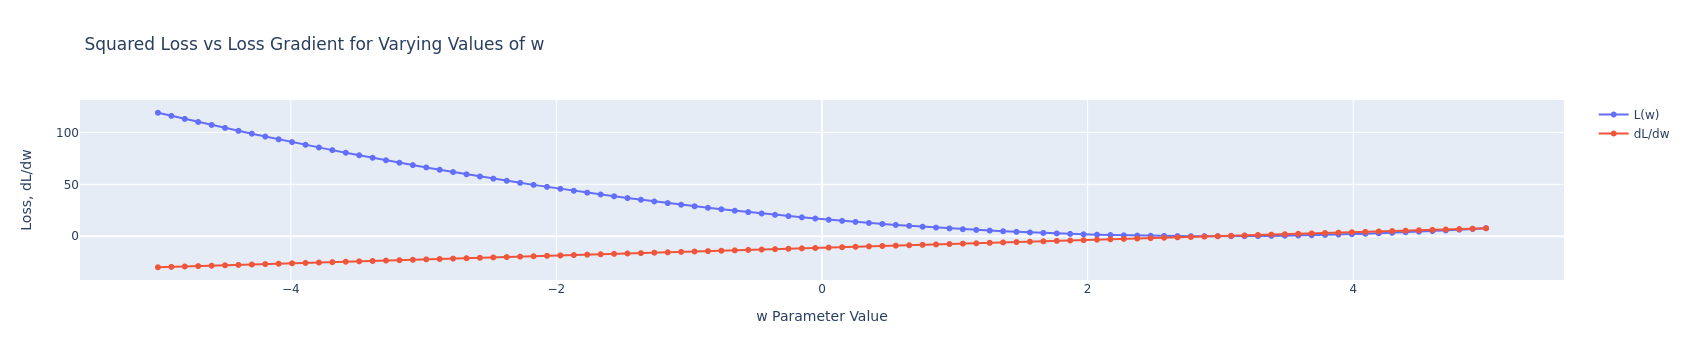

In [17]:
temp

So how much do we adjust our parameters $w$ and $b$?

Note that if we update our model to completely eliminate loss for each observation, then our model will bounce around between perfectly describing individual data points (and fail to capture some global structure).

### Gradient Descent

Gradient Descent is an optimization algorithm where after each guess, we adjust the parameter $w$ using the following formula:

$$w' = w - \lambda \frac{dL}{dw}$$

Where $\lambda$ is a parameter called the learning rate.

_Learning Rate_

A "penalty" on each update to limit overfitting on the basis of each individual point.

The exact value of the learning rate is a non-trivial hyperparameter to the model, and standard practice now is to vary it during training.

We will not cover this in depth, however.

In [18]:
lr = 1e-4 # Constant learning rate of 0.0001

# Let's see if our loss goes down!
loss = (y0 - (x0*w + b)).pow(2) # Old loss
print("Old Loss:", loss.item())

# Backprop loss
loss.backward()

# Gradient descent formula w' = w - (lr * w.grad)
with torch.no_grad(): # Don't record this calculation
    w -= lr * w.grad
    b -= lr * b.grad

print("New Loss (after update): ", ((y0 - (x0*w + b)).pow(2)).item()) # New loss

Old Loss: 9.027255058288574
New Loss (after update):  8.525734901428223


Let's see how this guess compares to our previous one

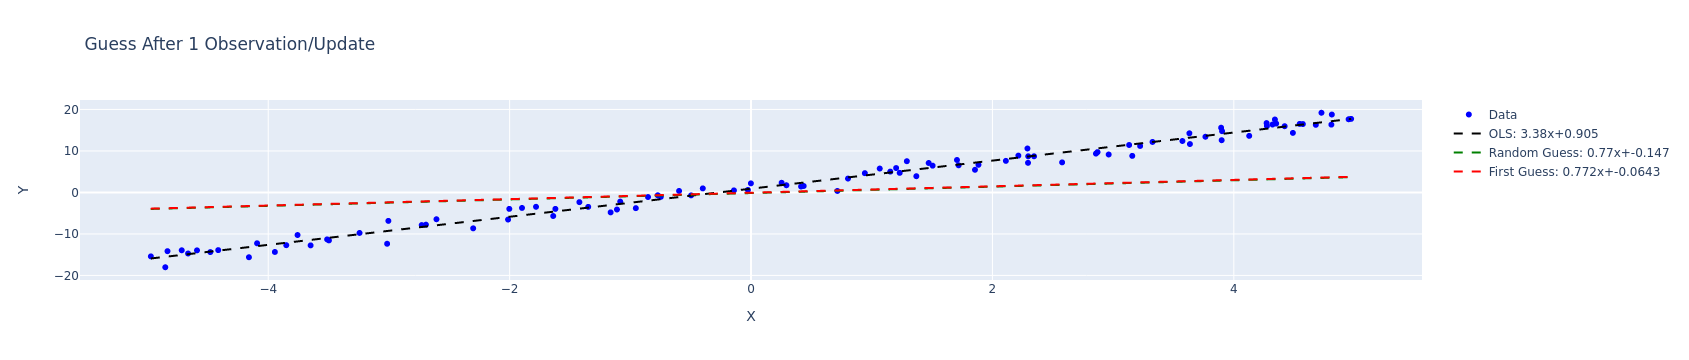

In [19]:
fig.add_trace(go.Scatter(x=[X_.min(), X_.max()],
                         y=[(X_.min() * w + b).detach().squeeze(), (X_.max() * w + b).detach().squeeze()],
                         mode='lines',
                         name=f'First Guess: {w.item():.3g}x+{b.item():.3g}',
                         line=dict(color='red', dash='dash')))
fig.update_layout(title='Guess After 1 Observation/Update')

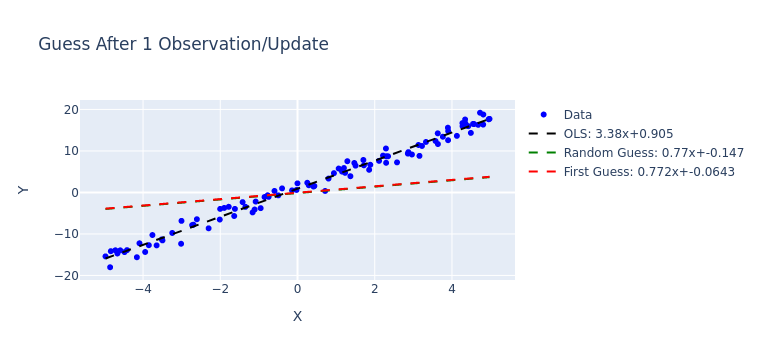

In [20]:
fig

We can repeat this for the entire dataset!

In [21]:
for i in tqdm(range(1, N_)):   # Skipping the observation we already have
    w.grad.zero_; b.grad.zero_ # Reset gradients
    x0 = X_[i]                 # Draw new samples
    y0 = y_[i]
    pred = (x0*w + b)          # Forward pass
    loss = (y0 - pred).pow(2)  # Loss calculation
    loss.backward()            # Backward pass 
    with torch.no_grad():      # Manual gradient descent
        w -= lr * w.grad
        b -= lr * b.grad

100%|██████████| 99/99 [00:00<00:00, 24978.11it/s]


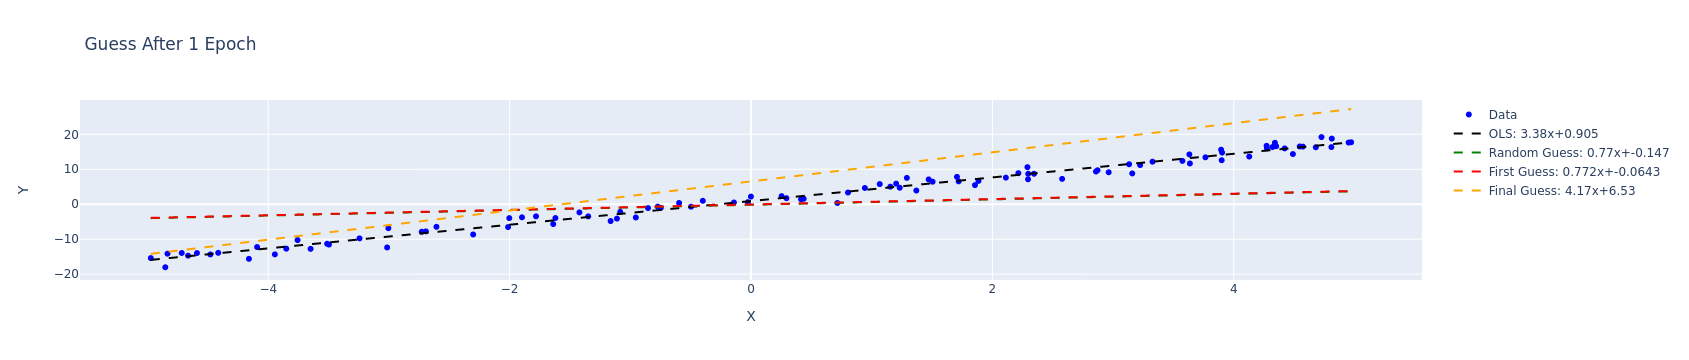

In [22]:
# Final figure
fig.add_trace(go.Scatter(x=[X_.min(), X_.max()],
                         y=[(X_.min() * w + b).detach().squeeze(), (X_.max() * w + b).detach().squeeze()],
                         mode='lines',
                         name=f'Final Guess: {w.item():.3g}x+{b.item():.3g}',
                         line=dict(color='Orange', dash='dash')))
fig.update_layout(title='Guess After 1 Epoch')
fig

## Part 2: Getting Harder

So far we've seen a slower and harder way to do regression.

Let's consider a problem that would be difficult (impossible) with a linear regression approach: the XOR problem.

It's easiest to visualize it first.

In [23]:
def generate_2d_data(problem: Literal['XOR', 'Moons']
                    ) -> tuple[np.ndarray, np.ndarray]:
    if problem=='XOR':
        N = 1000
        x1 = np.concatenate([rng.uniform(0, 100, N//4),
                            rng.uniform(-100, 0, N//4),
                            rng.uniform(0, 100, N//4),
                            rng.uniform(-100, 0, N//4)])
        x2 = np.concatenate([rng.uniform(-100, 0, N//4),
                            rng.uniform(0, 100, N//4),
                            rng.uniform(0, 100, N//4),
                            rng.uniform(-100, 0, N//4)])
        X = np.vstack([x1, x2]).T
        y = np.concatenate([np.zeros(shape=N//2), np.ones(shape=N//2)])
    elif problem=='Moons':
        X, y = datasets.make_moons(
            n_samples=500,
            random_state=0)
    return X, y
X, y = generate_2d_data('Moons')

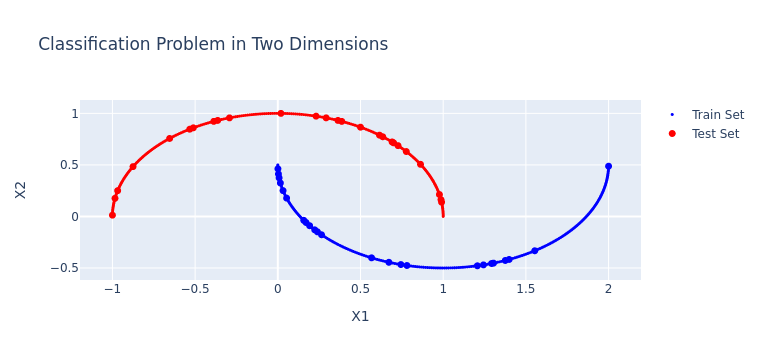

In [24]:
# Train-test split to simulate 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


# %% Visualize dataset, train/test split
fig = go.Figure()
fig.add_trace( # Visualize train data
    go.Scatter(x=X_train[:, 0],
               y=X_train[:, 1], 
                mode='markers',
                name='Train Set',
                hovertemplate="%{x:.3g}, %{y:.3g}",
                marker=dict(size=3, color=y_train, colorscale='bluered_r'),
                text=['Class 1' if y==1 else 'Class 0' for y in y_train]))
fig.add_trace( # Visualize test data
    go.Scatter(x=X_test[:, 0],
               y=X_test[:, 1],
               mode='markers',
               name='Test Set',
               hovertemplate="%{x:.3g}, %{y:.3g}",
               marker=dict(size=7, color=y_test, colorscale='bluered_r'),
               text=['Class 1' if y==1 else 'Class 0' for y in y_train]))
fig.update_layout(title='Classification Problem in Two Dimensions',
                  xaxis_title='X1',
                  yaxis_title='X2',
                  showlegend=True)
fig

In [25]:
# Move this to a separate file for convenience
# %% Model Visualization
class ModelVisualization():
    def __init__(self,
                 model: nn.Module,
                 X_test: np.ndarray,
                 y_test: np.ndarray,
                 h: float=1.0) -> None:
        self.model = model
        self.X = X_test
        self.y = y_test
        self.h = h
        self.build_grid(
            self.X[:,0].min(),
            self.X[:,0].max(),
            self.X[:,1].min(),
            self.X[:,1].max(),
            self.h)
        self.fit_grid()
        self.init_figure(mode='plotly')

    def build_grid(self,
                   xmin: float,
                   xmax: float,
                   ymin: float,
                   ymax: float,
                   h: float=1.0) -> np.ndarray:
        if all(e is None for e in [xmin, xmax, ymin, ymax]):
            xmin = self.X[:,0].min()
            xmax = self.X[:,0].max()
            ymin = self.X[:,1].min()
            ymax = self.X[:,1].max()
        self.grid_x1, self.grid_x2 = np.meshgrid(np.arange(xmin, xmax+h, h),
                                                 np.arange(ymin, ymax+h, h))
        self.points = np.stack([self.grid_x1.reshape(-1),
                                self.grid_x2.reshape(-1)],
                                axis=1)
        return self.points
    
    def fit_grid(self) -> np.ndarray:
        inputs = torch.tensor(self.points).float()
        preds = self.model(inputs).detach().numpy()
        self.preds = preds.reshape(self.grid_x1.shape)
        return self.preds
    
    def generate_pred_heatmap(self, step: int=0):
        # colors = px.colors.sequential.s
        # intervals = np.linspace(self.preds.min(), self.preds.max(), len(colors))
        # cs =  [[intervals[n], colors[n]]
        #         for s in [[i, i+1] for i in range(len(colors))]
        #         for n in s if n < len(colors)]
        # intervals = np.linspace(0, 1, len(colors))
        # cs = [[intervals[n], colors[n]] for n in range(len(colors))]
        hm = go.Heatmap(x=np.arange(self.grid_x1.min(), self.grid_x1.max()+self.h, self.h),
                        y=np.arange(self.grid_x2.min(), self.grid_x2.max()+self.h, self.h),
                        z=self.preds,
                        name='Preds: ' + str(step),
                        colorscale='Spectral',
                        # colorbar=dict(
                            # tick0=0,
                            # dtick=self.preds.ptp()//10,
                            # title='$\hat{y}$'),
                        hovertemplate="X1: %{x:.3g}, X2: %{y:.3g}: Pred: %{z:.3g}",
                        hoverongaps=False)
        return hm
    
    def init_figure(self, mode = Literal['matplotlib', 'plotly'],
                    **kwargs) -> Union[go.Figure, plt.Figure]:
        if mode == 'matplotlib':
            fig, ax = plt.subplots()
            ax.imshow(self.preds,
                      origin='lower',
                      extent=(self.grid_x1.min(), self.grid_x1.max(),
                              self.grid_x2.min(), self.grid_x2.max()))
            ax.scatter(self.X[:,0], self.X[:,1],
                    c=['#4444ff' if i<=0 else '#ff4444' for i in y],
                    alpha=0.5, s=4)
        elif mode == 'plotly':
            fig = go.Figure()
            fig.add_trace( # Scatter of test data
                go.Scattergl(
                    x=self.X[:, 0],
                    y=self.X[:, 1],
                    mode='markers',
                    name='Test Set',
                    marker=dict(
                        color=['blue' if i==1 else 'red' for i in y_test],
                        line=dict(width=1)),
                    text=y_test))
            fig.add_trace( # Predictions map
                self.generate_pred_heatmap())
            # Slider configuration
            self.total_steps = 1
            self.steps = []
            step = dict(method="update",
                        args=[{"visible": [False] * len(fig.data)},
                              {"title": "Step: " + str(self.total_steps)}])
            step["args"][0]["visible"][0] = True # Make Scatter visible
            step["args"][0]["visible"][-1] = True # Set step visible
            self.steps.append(step)
            sliders = [dict(
                active=0,
                currentvalue={"prefix": "Updates: "},
                pad={"t": self.total_steps},
                steps=self.steps)]
            
            fig.update_layout(title='Model Predictions',
                              xaxis_title='X1',
                              yaxis_title='X2',
                              legend_title_text='Predicted Value',
                              sliders=sliders)
        self.mode = mode
        self.fig = fig
        return self.fig

    def update_figure(self, model: nn.Module) -> Union[go.Figure, plt.Figure]:
        self.fit_grid()
        self.total_steps += 1
        self.fig.add_trace(self.generate_pred_heatmap(self.total_steps))
        # Update all previous steps
        for i, step in enumerate(self.steps):
            step['args'][0]['visible'] = [False] * len(self.fig.data)
            step["args"][0]["visible"][0] = True
            step["args"][0]["visible"][i+1] = True
        new_step = dict(method="update",
                        args=[{"visible": [False] * len(self.fig.data)},
                              {"title": "Step: " + str(self.total_steps)}])
        new_step["args"][0]["visible"][0] = True # Make Scatter visible
        new_step["args"][0]["visible"][-1] = True # Set update visible
        self.steps.append(new_step)
        sliders = [dict(
            active=self.total_steps-1,
            currentvalue={"prefix": "Updates: "},
            pad={"t": self.total_steps},
            steps=self.steps)]
        self.fig.update_layout(sliders=sliders)
        
        return self.fig


### Using Classes and Modules

In the previous section, we used vectors (tensors) to hold all of our parameters and updated them against data.

In this step we're going to change from our mathematician to our engineer hat.

Let's create reusable blueprints to hold our models (both the structure and the parameters) and then populate them with data.

In [26]:
# %% Usually we use modules instead ; Custom simple module
class SimpleLinearNN(nn.Module): # It's a subclass of nn.Module
    def __init__(self,
                 features_in: int=1,     # Number of features in 
                 features_out: int=1,    # Number of features out
                 bias: bool=True):       # Add bias parameter?
        super(SimpleLinearNN,            # This basically adds methods from
              self).__init__()           # nn.Module to this class.
        self.weights = nn.Parameter(     # Need to define as parameter so
            torch.empty(                 # optimizer knows to optimize it.
                features_in,
                features_out))
        nn.init.normal_(self.weights)    # Initialize to some sane values
        self.bias = nn.Parameter(        # Some models do not need a bias
            torch.empty(1, features_out) # parameter, this is one way
            ) if bias else 0             # to implement that.
        if bias:
            nn.init.normal_(self.bias)
    
    def forward(self, inputs):           # Every nn.Module needs a forward func
        preds = torch.matmul(            # Define forward pass 
            inputs, self.weights         # W∙X
            ) + self.bias                # + b
        return preds                     # return predictions

We create an instance of this blueprint and call it `slnn`.

_Ask why we set weights=2_

In [27]:
# Construct network
slnn = SimpleLinearNN(features_in=2, bias=True)

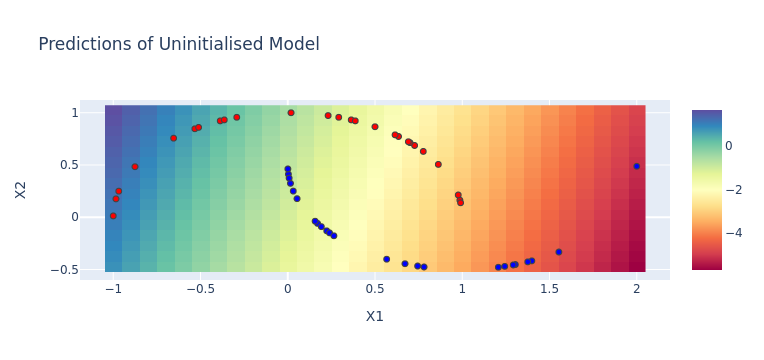

In [28]:
# %% Visualize the uninitialised model and its predictions
mv = ModelVisualization(slnn, X_test, y_test, h=0.1)
mv.fig.update_layout(title="Predictions of Uninitialised Model")

### Training a Module

This time, instead of using one observation at a time, we'll work with _batches_ of data.

In [29]:
# Again, let's convert our data to tensors
X_train, y_train = (torch.tensor(X_train, dtype=torch.float32),
                    torch.tensor(y_train, dtype=torch.float32
                                ).reshape(-1, 1)) # Needs to be 2D

# Use first 8 observations as first batch
inputs = X_train[:8, :]
labels = y_train[:8, :]

Instead of manually doing the gradient updates, we use an optimizer from `torch.optim`.

In this case I am using a Stochastic Gradient Descent (`SGD`) optimizer, which functions the same way as the manual updates we were doing above.

In most modern applications, we would use a better optimizer (namely `Adam` or its variants).

In [30]:
# Initialize optimizer
optim = torch.optim.SGD(slnn.parameters(), lr=5e-4)

# Reset the gradients
optim.zero_grad()

For the forward and backward pass, we can also use a built-in function for the loss.

In [31]:
# Forward pass: Data -> Predictions
preds = slnn(inputs) # We don't actually need to use the `.forward` function

# Loss calculation
loss_fn = nn.MSELoss()
loss = loss_fn(preds, labels)
loss.backward()

Now we can use the optimizer to update the weights with the `.step()` function.

In [32]:
# Update parameters
print(f"Weights: {slnn.weights}",
      f"Weights: {slnn.bias}",
      sep='\n')
print("="*12)
optim.step()
print("PARAMETER UPDATE")
print("="*12)
print(f"Weights: {slnn.weights}",
      f"Weights: {slnn.bias}",
      sep='\n')

Weights: Parameter containing:
tensor([[-2.1788],
        [ 0.5684]], requires_grad=True)
Weights: Parameter containing:
tensor([[-1.0845]], requires_grad=True)
PARAMETER UPDATE
Weights: Parameter containing:
tensor([[-2.1776],
        [ 0.5683]], requires_grad=True)
Weights: Parameter containing:
tensor([[-1.0818]], requires_grad=True)


### An Aside on Dataloaders

Note that above I manually selected the first 8 rows of the dataset to train the model.

This is an inefficient/inflexible approach.

Pytorch provides powerful tools for feeding data to your model.

It's a bit of a distraction to go into them for now, but we can come back at the end if there's time.


In [33]:
class SimpleDataset(Dataset):
    def __init__(self, X: torch.tensor, y: torch.tensor):
        self.features = X
        self.labels = y
    
    def __len__(self): # Required method 1; must return length of data as int
        return len(self.features)
    
    def __getitem__(self, idx: int): # Required method 2; how to grab data
        return self.features[idx, :], self.labels[idx, :]


dataset = SimpleDataset(X_train, y_train) # Instantiate dataset object
dataloader = DataLoader(dataset, batch_size=8, shuffle=True) # Wrap with DataLoader

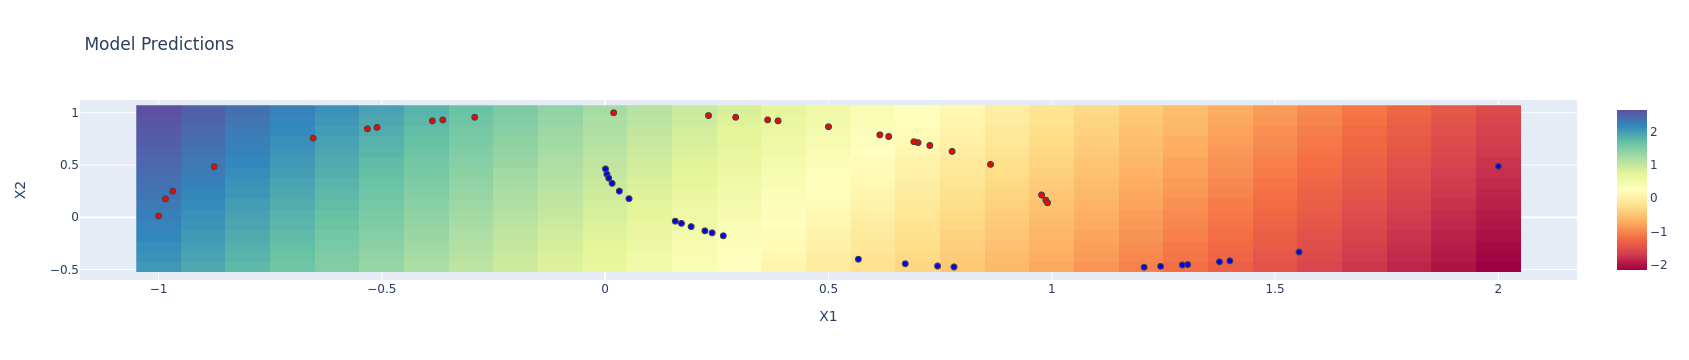

In [34]:
slnn = SimpleLinearNN(2)
optim = torch.optim.SGD(slnn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
mv = ModelVisualization(slnn, X_test, y_test, h=0.1)
mv.fig

In [35]:
epochs = 50
for epoch in tqdm(range(epochs)):
# Single epoch of training
    for bn, (inputs, labels) in enumerate(dataloader):
        # Reset gradients
        optim.zero_grad()
        # Forward
        preds = slnn(inputs)
        # Loss
        loss = loss_fn(preds, labels)
        # Backward
        loss.backward()
        # Update
        optim.step()

100%|██████████| 50/50 [00:00<00:00, 178.50it/s]


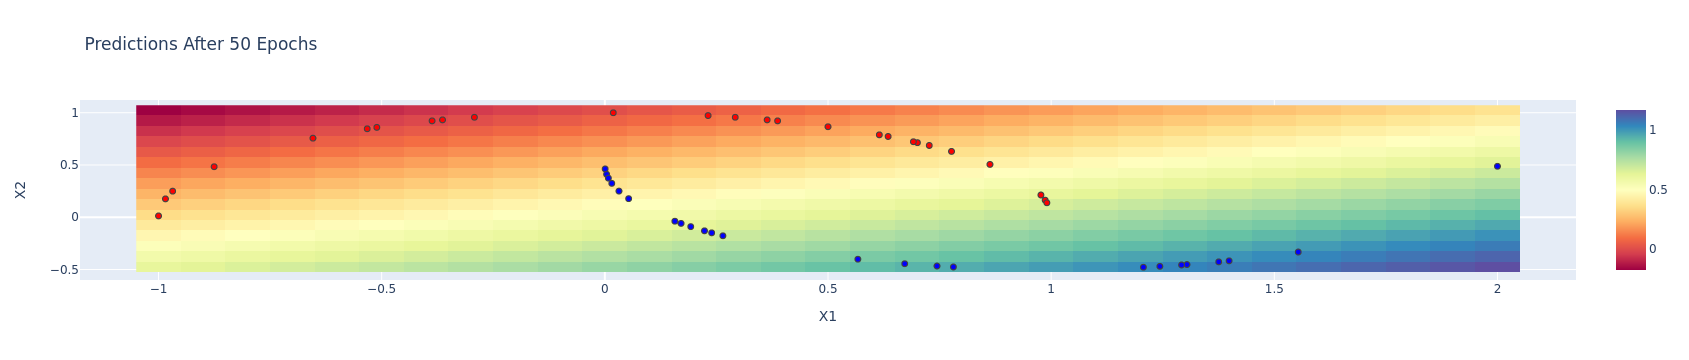

In [36]:
mv = ModelVisualization(slnn, X_test, y_test, h=0.1)
mv.fig.update_layout(title="Predictions After 50 Epochs")
mv.fig

### Improving the model

After 50 epochs, the model is doing roughly what we want. But there are a few improvements we might want:

- Better fit to response surface
- Classification instead of regression


Let's tackle the fit problem first (because the classification step is easy)

### Layering/Depth

Stacking and widening neural networks.

Let's revisit our original neural network. It has two inputs and a single output. We can represent it as the following diagram:

![Simple Neural Network](./part1/figures/nn2-1.svg)

In this diagram:

- nodes are data points
- edges are model weights

Therefore this diagram represents a regression model with X values, two weights (biases are omitted for ease of presentation), and a single output y.

But what if we create a wider network like the following?

![Simple Neural Network](./part1/figures/nn2-4.svg)

What is going on here?

In [37]:
widenn = SimpleLinearNN(features_in=2, features_out=4)
widenn(inputs)

tensor([[-0.5897, -0.2390,  0.1578, -1.3074],
        [-1.0900, -0.0531,  0.1963, -0.9368]], grad_fn=<AddBackward0>)

What does four outputs mean?

You can think of this as training four separate regression models that take the same inputs, and output four separate values.

How do we turn four predictions back into one?

We can use a new network!

In [38]:
widenn2 = SimpleLinearNN(features_in=4, features_out=1)

hidden_layer = widenn(inputs)
preds = widenn2(hidden_layer)
print(inputs.shape, hidden_layer.shape, preds.shape)

torch.Size([2, 2]) torch.Size([2, 4]) torch.Size([2, 1])


Combining the two networks, we get something that looks like this:

![Deep Neural Network](./part1/figures/nn2-4-1.svg)

Can we train our wide network?

Pytorch offers a convenient method for stacking networks:  `nn.Sequential`

In [39]:
sdnn = nn.Sequential(widenn, widenn2)
sdnn(inputs)

tensor([[1.3559],
        [2.3207]], grad_fn=<AddBackward0>)

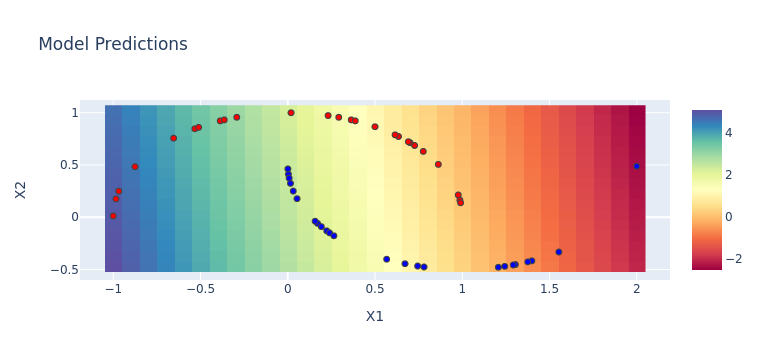

In [40]:
mvdnn = ModelVisualization(sdnn, X_test, y_test, h=0.1)
mvdnn.fig

Before we fit this model to the data, any guesses about how the prediction surface might change?

In [41]:
# We can calculate the average mistake before and after
nn.functional.mse_loss(                          # mse_loss function
    sdnn(torch.tensor(X_test).float()),          # Prediction
    torch.tensor(y_test).float().reshape(-1, 1)) # Truth

tensor(4.5299, grad_fn=<MseLossBackward0>)

In [42]:
# 50 training epochs
optim = torch.optim.SGD(sdnn.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
epochs = 50
for epoch in tqdm(range(epochs)):
    for bn, (inputs, labels) in enumerate(dataloader):
        optim.zero_grad()
        preds = sdnn(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optim.step()
# Test loss
nn.functional.mse_loss(                          # mse_loss function
    sdnn(torch.tensor(X_test).float()),          # Prediction
    torch.tensor(y_test).float().reshape(-1, 1)) # Truth

100%|██████████| 50/50 [00:00<00:00, 144.09it/s]


tensor(0.1076, grad_fn=<MseLossBackward0>)

But--prediction surface is still flat!

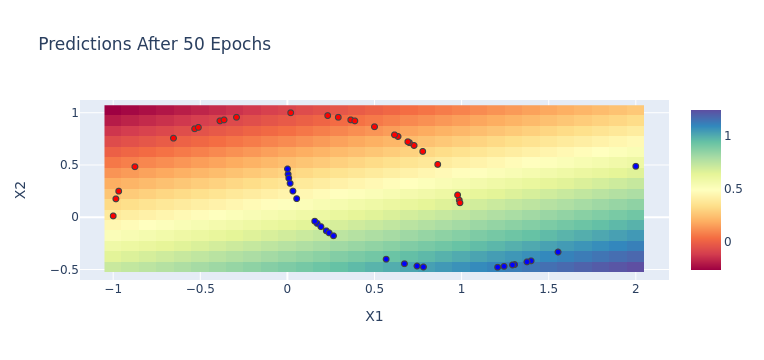

In [43]:
mvdnn = ModelVisualization(sdnn, X_test, y_test, h=0.1)
mvdnn.fig.update_layout(title="Predictions After 50 Epochs")
mvdnn.fig

It turns out that any linear combination of linear models reduces to a linear model. (A proof is beyond the scope of this workshop and also I haven't sat down to work it out).

### Activation Functions

The other key component to neural networks is the activation function.

You've probably already come across activation functions before--logistic regression!

Logistic regressions can be thought of as a sigmoid transformation on the output of a linear model.

Let's define a new neural network template that can take activation functions.

In [44]:
class Perceptron(nn.Module):
    def __init__(self,
                 features_in: int=1,
                 features_out: int=1,
                 activation: nn.modules.activation=nn.Sigmoid,
                 bias: bool=True):
        # This is same as before
        super(Perceptron,
              self).__init__()
        self.weights = nn.Parameter( torch.empty(features_in, features_out))
        nn.init.normal_(self.weights)
        self.bias = nn.Parameter(torch.empty(1, features_out)) if bias else 0
        if bias:
            nn.init.normal_(self.bias)
        # This is new
        self.activation = activation()
        
    
    def forward(self, inputs):
        preds = torch.matmul(inputs, self.weights) + self.bias
        output = self.activation(preds)  # Apply activation function
        return output

Aside: what _is_ the Sigmoid function?

Defined as $Sigmoid(x) = \frac{1}{1+exp(-x)}$.

We can visualize it:

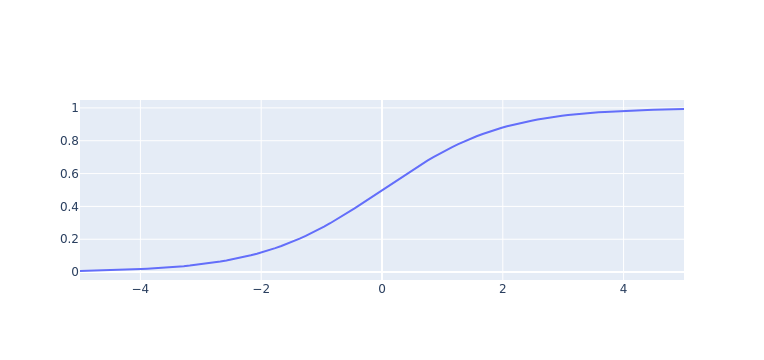

In [45]:
go.Figure(data=go.Scatter(x=torch.linspace(-5, 5, 100),
                          y=torch.sigmoid(torch.linspace(-5, 5, 100))))

The key takeaways:

- Symmetric over input 0
- 0 maps to 0.5
- Outputs are bounded between 0 and 1
- "Saturates" as input magnitudes increase

How do we use this for binary classification?

Let's train up a logistic classifier.

At this point we'll be doing a lot of training, so let's wrap our training in a function.

In [46]:
# Coding exercise - provide type hints for this function):
def train_n_epochs(model, dataloader, epochs, optim, loss_fn, lr=1e-3, verbose=True):
    optim = optim(model.parameters(), lr=lr)
    loss_fn = loss_fn()
    for epoch in tqdm(range(epochs)):
        for inputs, labels in dataloader:
            optim.zero_grad()
            preds = model(inputs)
            loss = loss_fn(preds, labels)
            loss.backward()
            optim.step()
    return model

def eval_model(model, x_test, y_test, loss_fn):
    with torch.no_grad():
        loss = loss_fn(
            model(torch.tensor(X_test).float()),
            torch.tensor(y_test).float().reshape(-1, 1))
    return loss

Let's instantiate, train and evaluate our model:

tensor(0.7706)


100%|██████████| 500/500 [00:02<00:00, 168.15it/s]

tensor(0.5916)


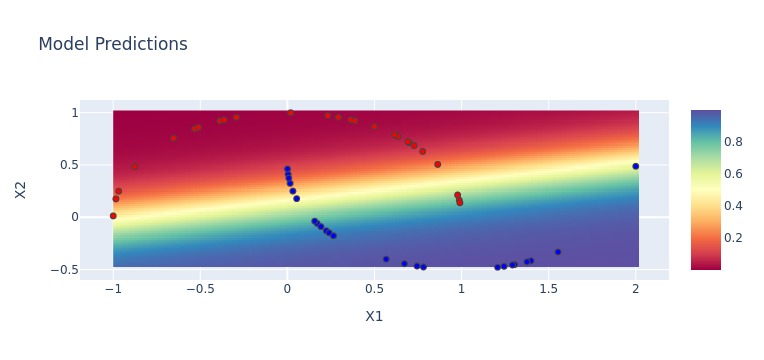

In [47]:
model = Perceptron(2, 1, nn.Sigmoid) # 2 inputs, 1 output, Sigmoid activation
loss_fn = nn.functional.binary_cross_entropy_with_logits # We use binary cross entropy for binary outcomes
print(eval_model(model, X_test, y_test, loss_fn)) # Eval starting point
train_n_epochs(model, dataloader, 500, torch.optim.SGD, nn.BCELoss, lr=0.03)
print(eval_model(model, X_test, y_test, loss_fn)) # Eval completion
ModelVisualization(model, X_test, y_test, h=0.02).fig

We still have a "flat" decision boundary, however. How can we improve this?

What happens if we stack two logistic models?

tensor(0.7277)


100%|██████████| 1000/1000 [00:08<00:00, 122.84it/s]

tensor(0.5934)


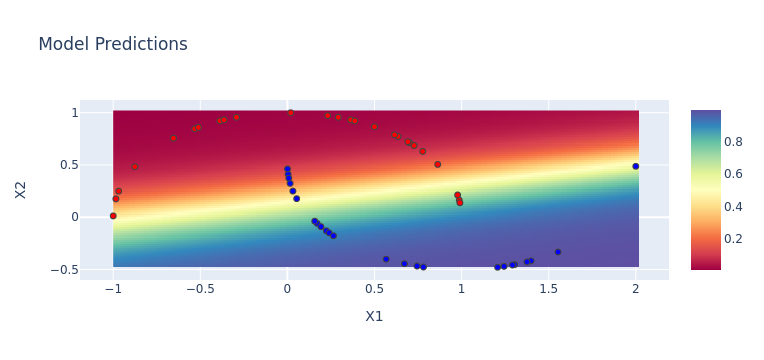

In [48]:
model = nn.Sequential(Perceptron(2, 2, nn.Sigmoid),
                       Perceptron(2, 1, nn.Sigmoid))
print(eval_model(model, X_test, y_test, loss_fn))
train_n_epochs(model, dataloader, 1000, torch.optim.SGD, nn.BCELoss, lr=0.03)
print(eval_model(model, X_test, y_test, loss_fn))
ModelVisualization(model, X_test, y_test, h=0.02).fig

What if we widen the middle layer?

tensor(0.7416)


100%|██████████| 1000/1000 [00:07<00:00, 126.45it/s]

tensor(0.5303)


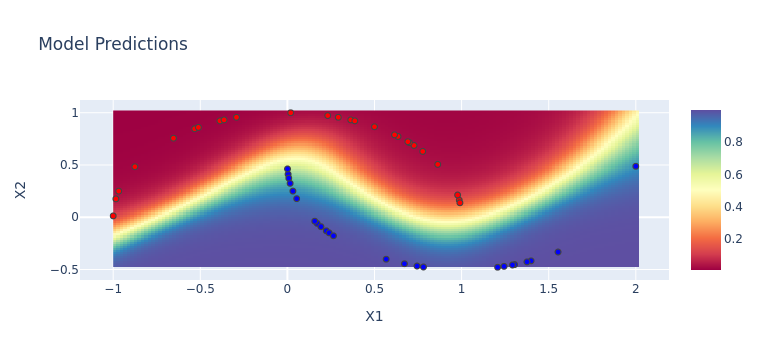

In [49]:
model = nn.Sequential(Perceptron(2, 4, nn.Sigmoid),
                      Perceptron(4, 1, nn.Sigmoid))
print(eval_model(model, X_test, y_test, loss_fn))
train_n_epochs(model, dataloader, 1000, torch.optim.SGD, nn.BCELoss, lr=0.03)
print(eval_model(model, X_test, y_test, loss_fn))
ModelVisualization(model, X_test, y_test, h=0.02).fig

Wider and deeper

tensor(0.7734)


100%|██████████| 1000/1000 [00:09<00:00, 101.95it/s]

tensor(0.5120)


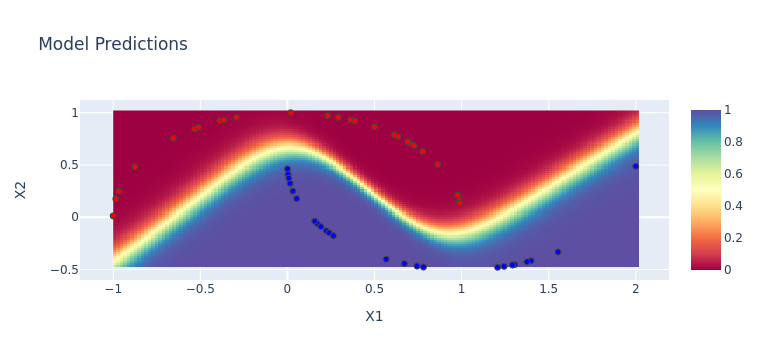

In [50]:
model = nn.Sequential(Perceptron(2, 8, nn.Sigmoid),
                      Perceptron(8, 8, nn.Sigmoid),
                      Perceptron(8, 1, nn.Sigmoid))
print(eval_model(model, X_test, y_test, loss_fn))
train_n_epochs(model, dataloader, 1000, torch.optim.SGD, nn.BCELoss, lr=0.03)
print(eval_model(model, X_test, y_test, loss_fn))
ModelVisualization(model, X_test, y_test, h=0.02).fig

### Training to completion

You might notice that the performance is a bit sensitive with respect to the random initialization.

Supposing that we took three splits of the data: train, eval, test

We could train on train, use eval to decide when it's done, and then test on test.

In [51]:
model = nn.Sequential(Perceptron(2, 4, nn.Sigmoid),
                      Perceptron(4, 1, nn.Sigmoid))
total_epochs=0
loss = eval_model(model, X_test, y_test, loss_fn)
while loss > 0.55:
    print(loss)
    train_n_epochs(model, dataloader, 100, torch.optim.SGD, nn.BCELoss, lr=0.03)
    loss = eval_model(model, X_test, y_test, loss_fn)
    total_epochs += 100

tensor(0.7970)


100%|██████████| 100/100 [00:00<00:00, 105.81it/s]


tensor(0.5995)


100%|██████████| 100/100 [00:00<00:00, 109.21it/s]


tensor(0.5949)


100%|██████████| 100/100 [00:00<00:00, 109.32it/s]


tensor(0.5940)


100%|██████████| 100/100 [00:00<00:00, 126.74it/s]


tensor(0.5940)


100%|██████████| 100/100 [00:00<00:00, 129.74it/s]


tensor(0.5931)


100%|██████████| 100/100 [00:00<00:00, 110.93it/s]


tensor(0.5932)


100%|██████████| 100/100 [00:00<00:00, 115.43it/s]


tensor(0.5928)


100%|██████████| 100/100 [00:00<00:00, 128.27it/s]


tensor(0.5918)


100%|██████████| 100/100 [00:00<00:00, 131.05it/s]


tensor(0.5782)


100%|██████████| 100/100 [00:00<00:00, 132.67it/s]


In [52]:
model = nn.Sequential(Perceptron(2, 4, nn.Sigmoid),
                      Perceptron(4, 4, nn.Sigmoid),
                      Perceptron(4, 4, nn.Sigmoid),
                      Perceptron(4, 1, nn.Sigmoid))
total_epochs=0
loss = eval_model(model, X_test, y_test, loss_fn)
while loss > 0.55:
    print(loss)
    train_n_epochs(model, dataloader, 100, torch.optim.SGD, nn.BCELoss, lr=0.03)
    loss = eval_model(model, X_test, y_test, loss_fn)
    total_epochs += 100

tensor(0.7075)


100%|██████████| 100/100 [00:01<00:00, 96.34it/s]


tensor(0.6068)


100%|██████████| 100/100 [00:01<00:00, 83.69it/s]


tensor(0.5943)


100%|██████████| 100/100 [00:01<00:00, 95.45it/s]


tensor(0.5901)


100%|██████████| 100/100 [00:01<00:00, 95.79it/s]


tensor(0.5827)


100%|██████████| 100/100 [00:01<00:00, 96.77it/s]


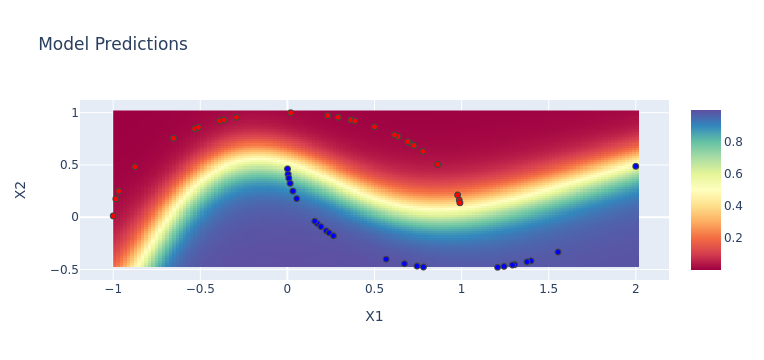

In [53]:
ModelVisualization(model, X_test, y_test, h=0.02).fig

On a final note, other activation functions exist:

![Activation Functions, from Kandel and Castelli 2020](https://www.researchgate.net/publication/339991922/figure/fig4/AS:870241110339586@1584493057180/Plot-of-different-activation-functions-a-Sigmoid-activation-function-b-Tanh.ppm)
<!-- ![Logistic Function](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1024px-Logistic-curve.svg.png) -->

In [54]:
model = nn.Sequential(Perceptron(2, 4, nn.ReLU),
                      Perceptron(4, 4, nn.ReLU),
                      Perceptron(4, 4, nn.ReLU),
                      Perceptron(4, 1, nn.Sigmoid))
total_epochs=0
loss = eval_model(model, X_test, y_test, loss_fn)
while loss > 0.55:
    print(loss)
    train_n_epochs(model, dataloader, 100, torch.optim.SGD, nn.BCELoss, lr=0.03)
    loss = eval_model(model, X_test, y_test, loss_fn)
    total_epochs += 100

tensor(0.7151)


100%|██████████| 100/100 [00:01<00:00, 90.66it/s]


tensor(0.5737)


100%|██████████| 100/100 [00:01<00:00, 81.42it/s]


tensor(0.5694)


100%|██████████| 100/100 [00:01<00:00, 82.80it/s]


tensor(0.5686)


100%|██████████| 100/100 [00:01<00:00, 92.91it/s]


tensor(0.5664)


100%|██████████| 100/100 [00:01<00:00, 93.62it/s]


tensor(0.5662)


100%|██████████| 100/100 [00:01<00:00, 94.51it/s]


tensor(0.5850)


100%|██████████| 100/100 [00:01<00:00, 94.84it/s]


tensor(0.5673)


100%|██████████| 100/100 [00:01<00:00, 93.76it/s]


tensor(0.5656)


100%|██████████| 100/100 [00:01<00:00, 94.14it/s]


tensor(0.5655)


100%|██████████| 100/100 [00:01<00:00, 94.53it/s]


tensor(0.5517)


100%|██████████| 100/100 [00:01<00:00, 94.42it/s]


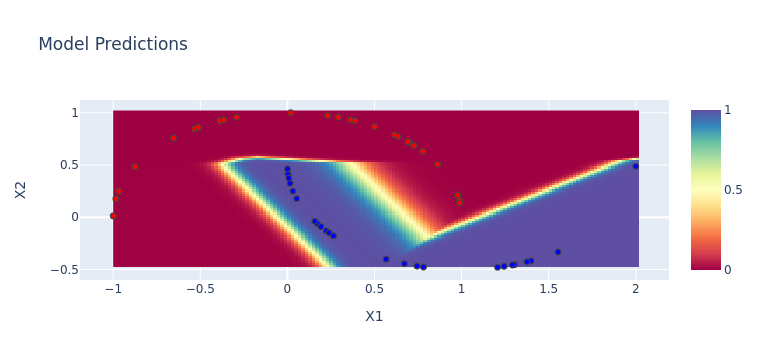

In [55]:
ModelVisualization(model, X_test, y_test, h=0.02).fig

# Graveyard